In [1250]:
import geopandas as gpd
import rasterio
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from PIL import Image

tif = rasterio.open("/home/kandelaki/git/SAM-Adapter-PyTorch/preprocessing/test_folder/images/NW00603.tif")
bbox = tif.bounds

# Reads the geojson only within the bounding box of the tif
mask = gpd.read_file("/home/kandelaki/git/SAM-Adapter-PyTorch/preprocessing/test_folder/geojson/PV_MUC_20220506_1_Florian.geojson", bbox = bbox)
mask = mask.to_crs(tif.crs)

# Save snapped mask to the current tid file
mask.to_file("/home/kandelaki/git/SAM-Adapter-PyTorch/preprocessing/test_folder/splits/" + "split_mask.geojson", driver='GeoJSON')

# Read the snapped mask]
snapped_mask = gpd.read_file("/home/kandelaki/git/SAM-Adapter-PyTorch/preprocessing/test_folder/splits/" + "split_mask.geojson")
snapped_mask = gpd.GeoSeries(data=snapped_mask["geometry"], crs=mask.crs)



In [1251]:
polygon_out_of_tile = Polygon.from_bounds(*tif.bounds)
polygon_out_of_tile = gpd.GeoSeries(data = polygon_out_of_tile, crs=mask.crs)

In [1252]:
distances = snapped_mask.geometry.apply(lambda x: snapped_mask.hausdorff_distance(x))

In [1253]:
# calculate threshold based on the patch_size
patch_size = 1024
a = tif.xy(0, 0)[0]
b = tif.xy(0, patch_size)[0]
dist = b - a
dist

204.80000000004657

In [1254]:
# Group the polygons based on the distance between them
threshold_distance = dist*0.9 # adjust as needed with the patch_size
groups = []
grouped_indices = set()

for i, distance_row in distances.iterrows():
    if i not in grouped_indices:
        group = distance_row[distance_row <= threshold_distance].index.tolist()
        groups.append(group)
        grouped_indices.update(group)



In [1255]:
# Unite points in each group into a single MultiPolygon
multipolygons = []
for group in groups:
    united = MultiPolygon()
    for i in group:
        united = united.union(snapped_mask.geometry[i])
    multipolygons.append(united)

In [1256]:
# Visualize the grouped polygons
near_polygons = gpd.GeoSeries(multipolygons, crs=snapped_mask.crs)
near_polygons.explore()

In [1257]:
centroids = near_polygons.centroid.to_crs(tif.crs)
centroids.explore()

In [1258]:
# Calculate the patch bounds for each centroid
# row, col as input for tif.xy()
# patch size < input_size
def calculate_patch_limits(centroid_coord_on_tile, patch_size, res):
    left = max(0, centroid_coord_on_tile[0] - patch_size/2)
    if left == 0:
        right = min(res[0], patch_size)
    else:
        right = min(res[0], centroid_coord_on_tile[0] + patch_size/2)

    top = max(0, centroid_coord_on_tile[1] - patch_size/2)
    if top == 0:
        bottom = min(res[1], patch_size)
    else:
        bottom = min(res[1], centroid_coord_on_tile[1] + patch_size/2)

    return left, bottom, right, top

def get_spatial_coordinates_from_pixels(tif, patch_bounds):
    left, top = tif.xy(patch_bounds[3], patch_bounds[0])
    right, bottom = tif.xy(patch_bounds[1], patch_bounds[2])

    return left, bottom, right, top

In [1259]:
# Run the example on ${index_example} centroid

index_example = 2

center_point = Point(centroids[index_example].x, centroids[index_example].y)
coords_of_centroid = center_point.coords[0]
coords_of_centroid

# row, col as output
centroid_coord_on_tile_y, centroid_coord_on_tile_x = tif.index(coords_of_centroid[0], coords_of_centroid[1])

res = tif.width, tif.height

patch_bounds = calculate_patch_limits((centroid_coord_on_tile_x, centroid_coord_on_tile_y), patch_size, res)
print(patch_bounds)

coords = get_spatial_coordinates_from_pixels(tif, patch_bounds)

patched_tile = gpd.GeoSeries(data=Polygon.from_bounds(*coords), crs=tif.crs)

print(polygon_out_of_tile.covers(patched_tile).bool())

(293.0, 5883.0, 1317.0, 4859.0)
True


/tmp/ipykernel_15399/4217761471.py:21: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  print(polygon_out_of_tile.covers(patched_tile).bool())


In [1260]:
# Visualize created patch on the tile
import folium

m = polygon_out_of_tile.explore(
)
patched_tile.explore(
    m=m, 
)

folium.TileLayer("CartoDB positron", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

In [1261]:
m

In [1262]:
near_polygon_group = gpd.GeoSeries(data = near_polygons[index_example], crs=snapped_mask.crs)

In [1263]:
import folium

m = patched_tile.explore(
)
near_polygon_group.explore(
    m=m, 
)

folium.TileLayer("CartoDB positron", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

In [1264]:
m

In [1265]:
# extract bounds from the patched tile
minx, miny, maxx, maxy = patched_tile.bounds.values[0]
print(minx, miny, maxx, maxy)
print(patched_tile)

684000.9375760264 5347585.01799902 684205.7375760265 5347789.81799902
0    POLYGON ((684000.938 5347585.018, 684000.938 5...
dtype: geometry


In [1266]:
# take all masks that is inside the patched tile

final_group =  snapped_mask.intersection(patched_tile[0])
unioned = final_group.unary_union


In [1267]:
# Write mask to a numpy array and save it
import numpy as np
import rasterio.features

w, h = patch_size, patch_size  

transform = rasterio.transform.from_bounds(minx,miny,maxx,maxy, w, h)

mask = rasterio.features.geometry_mask([unioned], transform=transform, invert=False, out_shape=(h, w))

np.zeros((w, h), dtype=np.uint8)

np.save('binary_mask.npy', mask)

(1024, 1024)


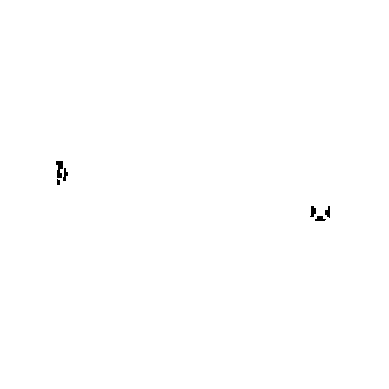

In [1268]:
# load and visualize
import matplotlib.pyplot as plt

# Load the binary mask from the NumPy file
mask = np.load('binary_mask.npy')

print(mask.shape)
# Get the shape of the mask
height, width = mask.shape

# Set the extent based on the shape of the mask
extent = (0, width, 0, height)

# Plot the binary mask with exact extent
plt.imshow(mask, cmap='gray', extent=extent, interpolation='nearest')
plt.axis('off')

# Display the plot (optional)
plt.show()

In [1269]:
# Crop and save the image and mask

# left, bottom, right, top in patch_bounds
patch_bounds
left, lower, right, top = patch_bounds
box = left, top, right, lower


with Image.open("/home/kandelaki/git/SAM-Adapter-PyTorch/preprocessing/test_folder/images/NW00603.tif") as img:
    img2 = img.crop(box)
    img2.save("NW00603_crop.png")

mask = np.load("binary_mask.npy")
img = Image.fromarray(mask)
img.save("binary_mask_crop.png")

/home/kandelaki/miniconda3/envs/preprocessing/lib/python3.12/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (145431540 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


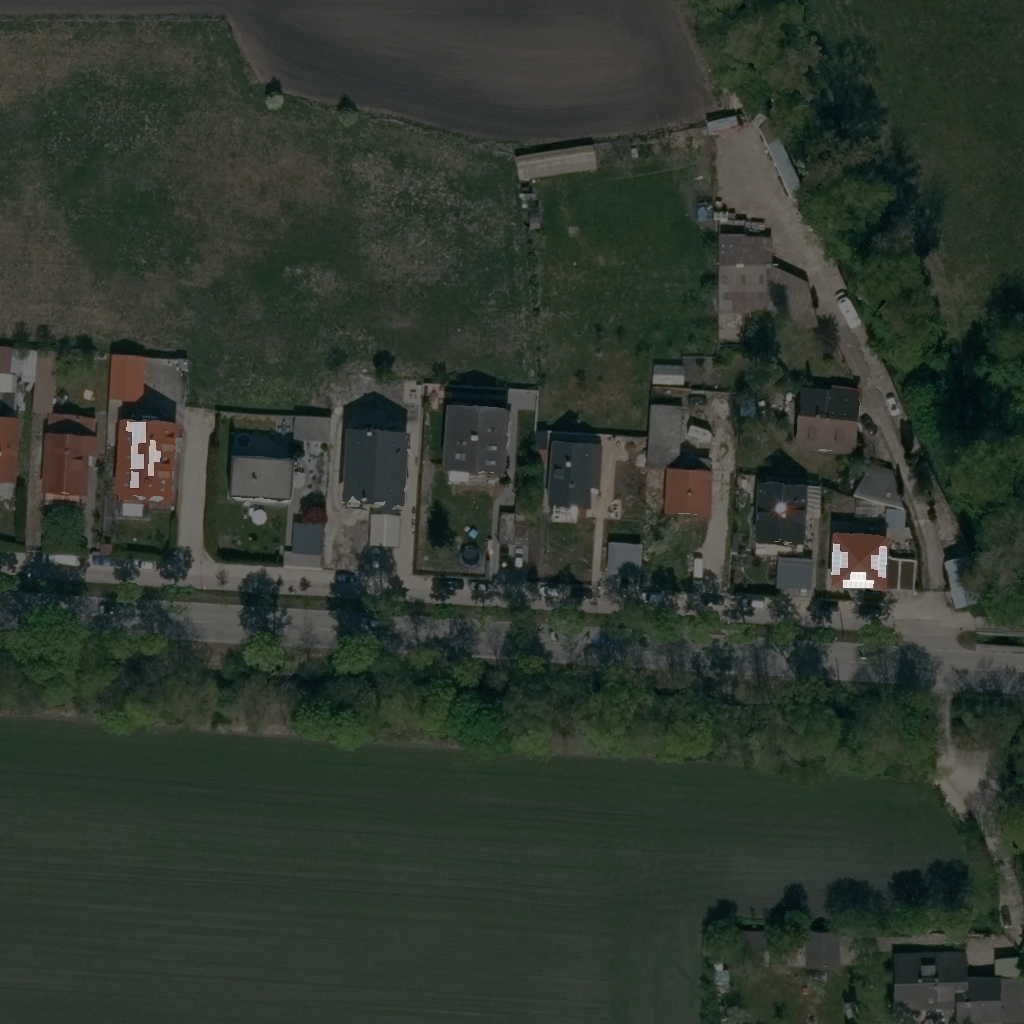

In [1270]:
# overlay the mask on the image and visualize
from PIL import Image, ImageOps
img = Image.open("NW00603_crop.png")
mask = Image.open("binary_mask_crop.png")
mask = mask.convert("L")
mask = ImageOps.invert(mask)
mask.putalpha(128)
img.paste(mask, (0, 0), mask)
img.save("overlay.png")
img.show()